# ME-NeuralFMU from the Modelica Conference 2021
Tutorial by Johannes Stoljar, Tobias Thummerer

----------

📚📚📚 This tutorial is achieved (so keeping it runnable is low priority). This tutorial further needs heavy refactoring. 📚📚📚

----------

*Last edit: 29.03.2023*

## License

In [1]:
# Copyright (c) 2021 Tobias Thummerer, Lars Mikelsons, Johannes Stoljar
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMIFlux.jl/blob/main/LICENSE) file in the project root for details.

## Motivation
The Julia Package *FMIFlux.jl* is motivated by the application of hybrid modeling. This package enables the user to integrate his simulation model between neural networks (NeuralFMU). For this, the simulation model must be exported as FMU (functional mock-up unit), which corresponds to a widely used standard. The big advantage of hybrid modeling with artificial neural networks is, that the effects that are difficult to model (because they might be unknown) can be easily learned by the neural networks. For this purpose, the NeuralFMU is trained with measurement data containing the not modeled physical effect. The final product is a simulation model including the originally not modeled effects. Another big advantage of the NeuralFMU is that it works with little data, because the FMU already contains the characteristic functionality of the simulation and only the missing effects are added.

NeuralFMUs do not need to be as easy as in this example. Basically a NeuralFMU can combine different ANN topologies that manipulate any FMU-input (system state, system inputs, time) and any FMU-output (system state derivative, system outputs, other system variables). However, for this example a NeuralFMU topology as shown in the following picture is used.

![NeuralFMU.svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/img/NeuralFMU.svg?raw=true)

*NeuralFMU (ME) from* [[1]](#Source).

## Introduction to the example
In this example, simplified modeling of a one-dimensional spring pendulum (without friction) is compared to a model of the same system that includes a nonlinear friction model. The FMU with the simplified model will be named *simpleFMU* in the following and the model with the friction will be named *realFMU*. At the beginning, the actual state of both simulations is shown, whereby clear deviations can be seen in the graphs. In addition, the initial states are changed for both models and these graphs are also contrasted, and the differences can again be clearly seen. The *realFMU* serves as a reference graph. The *simpleFMU* is then integrated into a NeuralFMU architecture and a training of the entire network is performed. After the training the final state is compared again to the *realFMU*. It can be clearly seen that by using the NeuralFMU, learning of the friction process has taken place.  


## Target group
The example is primarily intended for users who work in the field of first principle and/or hybrid modeling and are further interested in hybrid model building. The example wants to show how simple it is to combine FMUs with machine learning and to illustrate the advantages of this approach.


## Other formats
Besides, this [Jupyter Notebook](https://github.com/thummeto/FMIFlux.jl/blob/examples/examples/src/modelica_conference_2021.ipynb) there is also a [Julia file](https://github.com/thummeto/FMIFlux.jl/blob/examples/examples/src/modelica_conference_2021.jl) with the same name, which contains only the code cells. For the documentation there is a [Markdown file](https://github.com/thummeto/FMIFlux.jl/blob/examples/examples/src/modelica_conference_2021.md) corresponding to the notebook.  


## Getting started

### Installation prerequisites
|     | Description                       | Command                   |   
|:----|:----------------------------------|:--------------------------|
| 1.  | Enter Package Manager via         | ]                         |
| 2.  | Install FMI via                   | add FMI                   | 
| 3.  | Install FMIFlux via               | add FMIFlux               | 
| 4.  | Install FMIZoo via                | add FMIZoo                | 
| 5.  | Install DifferentialEquations via | add DifferentialEquations |  
| 6.  | Install Plots via                 | add Plots                 | 
| 7.  | Install Random via                | add Random                | 

## Code section

To run the example, the previously installed packages must be included. 

In [2]:
# imports
using FMI
using FMIFlux
using FMIFlux.Flux
using FMIZoo
using DifferentialEquations: Tsit5
using Plots

# set seed
import Random
Random.seed!(1234);

After importing the packages, the path to the *Functional Mock-up Units* (FMUs) is set. The exported FMU is a model meeting the *Functional Mock-up Interface* (FMI) Standard. The FMI is a free standard ([fmi-standard.org](http://fmi-standard.org/)) that defines a container and an interface to exchange dynamic models using a combination of XML files, binaries and C code zipped into a single file. 

The object-orientated structure of the *SpringPendulum1D* (*simpleFMU*) can be seen in the following graphic and corresponds to a simple modeling.

![svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/img/SpringPendulum1D.svg?raw=true)

In contrast, the model *SpringFrictionPendulum1D* (*realFMU*) is somewhat more accurate, because it includes a friction component. 

![svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/img/SpringFrictionPendulum1D.svg?raw=true)

Next, the start time and end time of the simulation are set. Finally, a step size is specified to store the results of the simulation at these time steps.

In [3]:
tStart = 0.0
tStep = 0.01
tStop = 4.0
tSave = collect(tStart:tStep:tStop)

401-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 ⋮
 3.89
 3.9
 3.91
 3.92
 3.93
 3.94
 3.95
 3.96
 3.97
 3.98
 3.99
 4.0

### RealFMU

In the next lines of code the FMU of the *realFMU* model from *FMIZoo.jl* is loaded and the information about the FMU is shown.  

In [4]:
realFMU = loadFMU("SpringFrictionPendulum1D", "Dymola", "2022x"; type=:ME)
info(realFMU)

#################### Begin information for FMU ####################
	Model name:			SpringFrictionPendulum1D
	FMI-Version:			2.0
	GUID:				{2e178ad3-5e9b-48ec-a7b2-baa5669efc0c}
	Generation tool:		Dymola Version 2022x (64-bit), 2021-10-08
	Generation time:		2022-05-19T06:54:12Z
	Var. naming conv.:		structured
	Event indicators:		24
	Inputs:				0
	Outputs:			0
	States:				2
		33554432 ["mass.s"]
		33554433 ["mass.v", "mass.v_relfric"]
	Parameters:			12
		16777216 ["fricScale"]
		16777217 ["s0"]
		16777218 ["v0"]
		16777219 ["fixed.s0"]
		...
		16777223 ["mass.smin"]
		16777224 ["mass.v_small"]
		16777225 ["mass.L"]
		16777226 ["mass.m"]
		16777227 ["mass.fexp"]
	Supports Co-Simulation:		true
		Model identifier:	SpringFrictionPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringFrictionPendulum1D
		Get/Set State:		true
		Serialize 

In the following two subsections, the *realFMU* is simulated twice with different initial states to show what effect the choice of initial states has.

#### Default initial states

In the next steps the parameters are defined. The first parameter is the initial position of the mass, which is initialized with $0.5m$, the second parameter is the initial velocity, which is initialized with $0\frac{m}{s}$. In the function `fmiSimulate()` the *realFMU* is simulated, still specifying the start and end time, the parameters and which variables are recorded. After the simulation is finished the result of the *realFMU* can be plotted. This plot also serves as a reference for the other model (*simpleFMU*). The extracted data will still be needed later on.

Simulating ME-FMU ...   0%|█                             |  ETA: N/A

Simulating ME-FMU ... 100%|██████████████████████████████| Time: 0:00:18


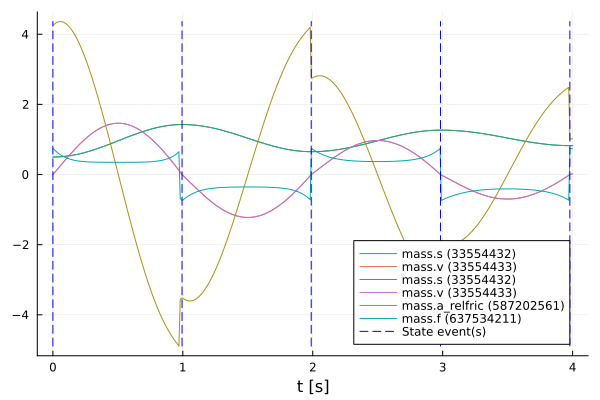

In [5]:
initStates = ["s0", "v0"]
x₀ = [0.5, 0.0]
params = Dict(zip(initStates, x₀))
vrs = ["mass.s", "mass.v", "mass.a", "mass.f"]

realSimData = simulate(realFMU, (tStart, tStop); parameters=params, recordValues=vrs, saveat=tSave)
posReal = getValue(realSimData, "mass.s")
velReal = getValue(realSimData, "mass.v")
plot(realSimData)

#### Define functions

Also, a function to extract the position and velocity from the simulation data is created.

In [6]:
function extractPosVel(simData)
    if simData.states === nothing
        posData = getValue(simData, "mass.s")
        velData = getValue(simData, "mass.v")
    else
        posData = getState(simData, 1; isIndex=true)
        velData = getState(simData, 2; isIndex=true)
    end

    return posData, velData
end

extractPosVel (generic function with 1 method)

#### Modified initial states

In contrast to the previous section, other initial states are selected. The position of the mass is initialized with $1.0m$ and the velocity is initialized with $-1.5\frac{m}{s}$. With the modified initial states the *realFMU* is simulated and a graph is generated.

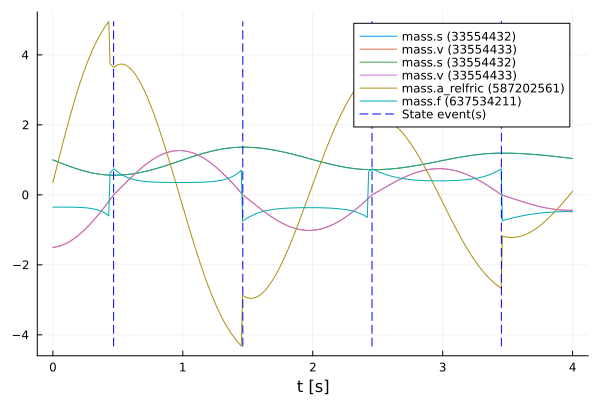

In [7]:
xMod₀ = [1.0, -1.5]
realSimDataMod = simulate(realFMU, (tStart, tStop); parameters=Dict(zip(initStates, xMod₀)), recordValues=vrs, saveat=tSave)
plot(realSimDataMod)

### SimpleFMU

The following lines load the *simpleFMU* from *FMIZoo.jl*. 

In [8]:
simpleFMU = loadFMU("SpringPendulum1D", "Dymola", "2022x"; type=:ME)
info(simpleFMU)

#################### Begin information for FMU ####################
	Model name:			SpringPendulum1D
	FMI-Version:			2.0
	GUID:				{fc15d8c4-758b-48e6-b00e-5bf47b8b14e5}
	Generation tool:		Dymola Version 2022x (64-bit), 2021-10-08
	Generation time:		2022-05-19T06:54:23Z
	Var. naming conv.:		structured
	Event indicators:		0
	Inputs:				0
	Outputs:			0
	States:				2
		33554432 ["mass.s"]
		33554433 ["mass.v"]
	Parameters:			7
		16777216 ["mass_s0"]
		16777217 ["mass_v0"]
		16777218 ["fixed.s0"]
		16777219 ["spring.c"]
		16777220 ["spring.s_rel0"]
		16777221 ["mass.m"]
		16777222 ["mass.L"]
	Supports Co-Simulation:		true
		Model identifier:	SpringPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
##################### End information for FMU #######

The differences between both systems can be clearly seen from the plots in the subchapters. In the plot for the *realFMU* it can be seen that the oscillation continues to decrease due to the effect of the friction. If you simulate long enough, the oscillation would come to a standstill in a certain time. The oscillation in the *simpleFMU* behaves differently, since the friction was not taken into account here. The oscillation in this model would continue to infinity with the same oscillation amplitude. From this observation the desire of an improvement of this model arises.     


In the following two subsections, the *simpleFMU* is simulated twice with different initial states to show what effect the choice of initial states has.

#### Default initial states

Similar to the simulation of the *realFMU*, the *simpleFMU* is also simulated with the default values for the position and velocity of the mass and then plotted. There is one difference, however, as another state representing a fixed displacement is set. In addition, the last variable is also removed from the variables to be plotted.

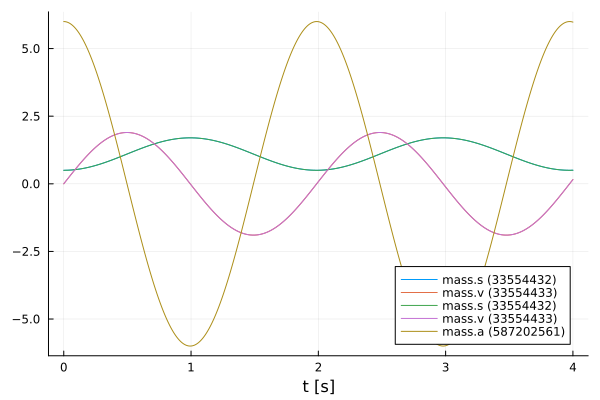

In [9]:
initStates = ["mass_s0", "mass_v0", "fixed.s0"]
displacement = 0.1
xSimple₀ = vcat(x₀, displacement)
vrs = vrs[1:end-1]

simpleSimData = simulate(simpleFMU, (tStart, tStop); parameters=Dict(zip(initStates, xSimple₀)), recordValues=vrs, saveat=tSave)
plot(simpleSimData)

#### Modified initial states

The same values for the initial states are used for this simulation as for the simulation from the *realFMU* with the modified initial states.

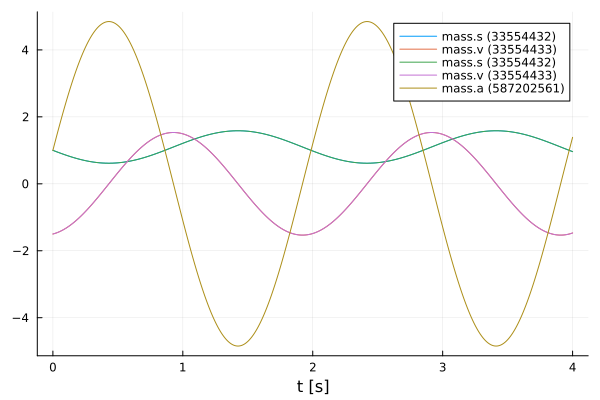

In [10]:
xSimpleMod₀ = vcat(xMod₀, displacement)

simpleSimDataMod = simulate(simpleFMU, (tStart, tStop); parameters=Dict(zip(initStates, xSimpleMod₀)), recordValues=vrs, saveat=tSave)
plot(simpleSimDataMod)

## NeuralFMU

#### Loss function

In order to train our model, a loss function must be implemented. The solver of the NeuralFMU can calculate the gradient of the loss function. The gradient descent is needed to adjust the weights in the neural network so that the sum of the error is reduced and the model becomes more accurate.

The error function in this implementation consists of the mean of the mean squared errors. The first part of the addition is the deviation of the position and the second part is the deviation of the velocity. The mean squared error (mse) for the position consists from the real position of the *realFMU* simulation (posReal) and the position data of the network (posNet). The mean squared error for the velocity consists of the real velocity of the *realFMU* simulation (velReal) and the velocity data of the network (velNet).
$$ e_{loss} = \frac{1}{2} \Bigl[ \frac{1}{n} \sum\limits_{i=0}^n (posReal[i] - posNet[i])^2 + \frac{1}{n} \sum\limits_{i=0}^n (velReal[i] - velNet[i])^2 \Bigr]$$

In [11]:
# loss function for training
function lossSum(p)
    global x₀
    solution = neuralFMU(x₀; p=p)

    posNet, velNet = extractPosVel(solution)

    (FMIFlux.Losses.mse(posReal, posNet) + FMIFlux.Losses.mse(velReal, velNet)) / 2.0
end

lossSum (generic function with 1 method)

#### Callback

To output the loss in certain time intervals, a callback is implemented as a function in the following. Here a counter is incremented, every fiftieth pass the loss function is called and the average error is printed out. Also, the parameters for the velocity in the first layer are kept to a fixed value.

In [12]:
# callback function for training
global counter = 0
function callb(p)
    global counter
    counter += 1

    # freeze first layer parameters (2,4,6) for velocity -> (static) direct feed trough for velocity
    # parameters for position (1,3,5) are learned
    p[1][2] = 0.0
    p[1][4] = 1.0
    p[1][6] = 0.0

    if counter % 50 == 1
        avgLoss = lossSum(p[1])
        @info "  Loss [$counter]: $(round(avgLoss, digits=5))
        Avg displacement in data: $(round(sqrt(avgLoss), digits=5))
        Weight/Scale: $(paramsNet[1][1])   Bias/Offset: $(paramsNet[1][5])"
    end
end

callb (generic function with 1 method)

#### Functions for plotting

In this section some important functions for plotting are defined. The function `generate_figure()` creates a new figure object and sets some attributes.

In [13]:
function generate_figure(title, xLabel, yLabel, xlim=:auto)
    plot(
        title=title, xlabel=xLabel, ylabel=yLabel, linewidth=2,
        xtickfontsize=12, ytickfontsize=12, xguidefontsize=12, yguidefontsize=12,
        legendfontsize=12, legend=:topright, xlim=xlim)
end

generate_figure (generic function with 2 methods)

In the following function, the data of the *realFMU*, *simpleFMU* and *neuralFMU* are summarized and displayed in a graph.

In [14]:
function plot_results(title, xLabel, yLabel, interval, realData, simpleData, neuralData)
    linestyles = [:dot, :solid]
    
    fig = generate_figure(title, xLabel, yLabel)
    plot!(fig, interval, simpleData, label="SimpleFMU", linewidth=2)
    plot!(fig, interval, realData, label="Reference", linewidth=2)
    for i in 1:length(neuralData)
        plot!(fig, neuralData[i][1], neuralData[i][2], label="NeuralFMU ($(i*2500))", 
                    linewidth=2, linestyle=linestyles[i], linecolor=:green)
    end
    display(fig)
end

plot_results (generic function with 1 method)

This is the superordinate function, which at the beginning extracts the position and velocity from the simulation data (`realSimData`, `realSimDataMod`, `simpleSimData`,..., `solutionAfterMod`). Four graphs are then generated, each comparing the corresponding data from the *realFMU*, *simpleFMU*, and *neuralFMU*. The comparison is made with the simulation data from the simulation with the default and modified initial states. According to the data, the designation of the title and the naming of the axes is adapted.

In [15]:
function plot_all_results(realSimData, realSimDataMod, simpleSimData, 
        simpleSimDataMod, solutionAfter, solutionAfterMod)    
    # collect all data
    posReal, velReal = extractPosVel(realSimData)
    posRealMod, velRealMod = extractPosVel(realSimDataMod)
    posSimple, velSimple = extractPosVel(simpleSimData)
    posSimpleMod, velSimpleMod = extractPosVel(simpleSimDataMod)
    
    run = length(solutionAfter)
    
    posNeural, velNeural = [], []
    posNeuralMod, velNeuralMod = [], []
    for i in 1:run
        dataNeural = extractPosVel(solutionAfter[i])
        time = getTime(solutionAfter[i])

        push!(posNeural, (time, dataNeural[1]))
        push!(velNeural, (time, dataNeural[2]))
        
        dataNeuralMod = extractPosVel(solutionAfterMod[i])
        time = getTime(solutionAfterMod[i])
        push!(posNeuralMod, (time, dataNeuralMod[1]))
        push!(velNeuralMod, (time, dataNeuralMod[2]))
    end
         
    # plot results s (default initial states)
    xLabel="t [s]"
    yLabel="mass position [m]"
    title = "Default: Mass position after Run: $(run)"
    plot_results(title, xLabel, yLabel, tSave, posReal, posSimple, posNeural)

    # plot results s (modified initial states)
    title = "Modified: Mass position after Run: $(run)"
    plot_results(title, xLabel, yLabel, tSave, posRealMod, posSimpleMod, posNeuralMod)

    # plot results v (default initial states)
    yLabel="mass velocity [m/s]"
    title = "Default: Mass velocity after Run: $(run)"
    plot_results(title, xLabel, yLabel, tSave, velReal, velSimple, velNeural)

    # plot results v (modified initial states)    
    title = "Modified: Mass velocity after Run: $(run)"
    plot_results(title, xLabel, yLabel, tSave, velRealMod, velSimpleMod, velNeuralMod)
end

plot_all_results (generic function with 1 method)

The function `plot_friction_model()` compares the friction model of the *realFMU*, *simpleFMU* and *neuralFMU*. For this, the velocity and force from the simulation data of the *realFMU* is needed. The force data is calculated with the extracted last layer of the *neuralFMU* to the real velocity in line 9 by iterating over the vector `velReal`. In the next rows, the velocity and force data (if available) for each of the three FMUs are combined into a matrix. The first row of the matrix corresponds to the later x-axis and here the velocity is plotted. The second row corresponds to the y-axis and here the force is plotted. This matrix is sorted and plotted by the first entries (velocity) with the function `sortperm()`. The graph with at least three graphs is plotted in line 33. As output this function has the forces of the *neuralFMU*.

In [16]:
function plot_friction_model!(realSimData, netBottom, forces)    
    linestyles = [:dot, :solid]
    
    velReal = getValue(realSimData, "mass.v")
    forceReal = getValue(realSimData, "mass.f")

    push!(forces, zeros(length(velReal)))
    for i in 1:length(velReal)
        forces[end][i] = -netBottom([velReal[i], 0.0])[2]
    end

    run = length(forces) 
    
    fig = generate_figure("Friction model $(run)", "v [m/s]", "friction force [N]", (-1.25, 1.25))

    fricSimple = hcat(velReal, zeros(length(velReal)))
    fricSimple[sortperm(fricSimple[:, 1]), :]
    Plots.plot!(fig, fricSimple[:,1], fricSimple[:,2], label="SimpleFMU", linewidth=2)

    fricReal = hcat(velReal, forceReal)
    fricReal[sortperm(fricReal[:, 1]), :]
    plot!(fig, fricReal[:,1], fricReal[:,2], label="reference", linewidth=2)

    for i in 1:run
        fricNeural = hcat(velReal, forces[i])
        fricNeural[sortperm(fricNeural[:, 1]), :]
        plot!(fig, fricNeural[:,1], fricNeural[:,2], label="NeuralFMU ($(i*2500))", 
                    linewidth=2, linestyle=linestyles[i], linecolor=:green)
        @info "Friction model $i mse: $(FMIFlux.Losses.mse(fricNeural[:,2], fricReal[:,2]))"
    end
    flush(stderr)

    display(fig)
    
    return nothing
end

plot_friction_model! (generic function with 1 method)

The following function is used to display the different displacement modells of the *realFMU*, *simpleFMU* and *neuralFMU*. The displacement of the *realFMU* and *simpleFMU* is very trivial and is only a constant. The position data of the *realFMU* is needed to calculate the displacement. The displacement for the *neuralFMU* is calculated using the first extracted layer of the neural network, subtracting the real position and the displacement of the *simpleFMU*. Also in this function, the graphs of the three FMUs are compared in a plot.

In [17]:
function plot_displacement_model!(realSimData, netTop, displacements, tSave, displacement)
    linestyles = [:dot, :solid]
    
    posReal = getValue(realSimData, "mass.s")
    
    push!(displacements, zeros(length(posReal)))
    for i in 1:length(posReal)
        displacements[end][i] = netTop([posReal[i], 0.0])[1] - posReal[i] - displacement
    end

    run = length(displacements)
    fig = generate_figure("Displacement model $(run)", "t [s]", "displacement [m]")
    plot!(fig, [tSave[1], tSave[end]], [displacement, displacement], label="simpleFMU", linewidth=2)
    plot!(fig, [tSave[1], tSave[end]], [0.0, 0.0], label="reference", linewidth=2)
    for i in 1:run
        plot!(fig, tSave, displacements[i], label="NeuralFMU ($(i*2500))", 
                    linewidth=2, linestyle=linestyles[i], linecolor=:green)
    end

    display(fig)
    
    return nothing
end

plot_displacement_model! (generic function with 1 method)

#### Structure of the NeuralFMU

In the following, the topology of the NeuralFMU is constructed. It consists of a dense layer that has exactly as many inputs and outputs as the model has states `numStates` (and therefore state derivatives). It also sets the initial weights and offsets for the first dense layer, as well as the activation function, which consists of the identity. An input layer follows, which then leads into the *simpleFMU* model. The ME-FMU computes the state derivatives for a given system state. Following the *simpleFMU* is a dense layer that has `numStates` states. The output of this layer consists of 8 output nodes and a *identity* activation function. The next layer has 8 input and output nodes with a *tanh* activation function. The last layer is again a dense layer with 8 input nodes and the number of states as outputs. Here, it is important that no *tanh*-activation function follows, because otherwise the pendulums state values would be limited to the interval $[-1;1]$.

In [18]:
# NeuralFMU setup
numStates = getNumberOfStates(simpleFMU)

# diagonal matrix 
initW = zeros(numStates, numStates)
for i in 1:numStates
    initW[i,i] = 1
end

net = Chain(Dense(numStates, numStates,  identity),
            x -> simpleFMU(x=x, dx_refs=:all),
            Dense(numStates, 8, identity),
            Dense(8, 8, tanh),
            Dense(8, numStates))

Chain(
  Dense(2 => 2),                        # 6 parameters
  var"#1#2"(),
  Dense(2 => 8),                        # 24 parameters
  Dense(8 => 8, tanh),                  # 72 parameters
  Dense(8 => 2),                        # 18 parameters
)                   # Total: 8 arrays, 120 parameters, 992 bytes.

#### Definition of the NeuralFMU

The instantiation of the ME-NeuralFMU is done as a one-liner. The FMU (*simpleFMU*), the structure of the network `net`, start `tStart` and end time `tStop`, the numerical solver `Tsit5()` and the time steps `tSave` for saving are specified.

In [19]:
neuralFMU = ME_NeuralFMU(simpleFMU, net, (tStart, tStop), Tsit5(); saveat=tSave);

#### Plot before training

Here the state trajectory of the *simpleFMU* is recorded. Doesn't really look like a pendulum yet, but the system is random initialized by default. In the plots later on, the effect of learning can be seen.

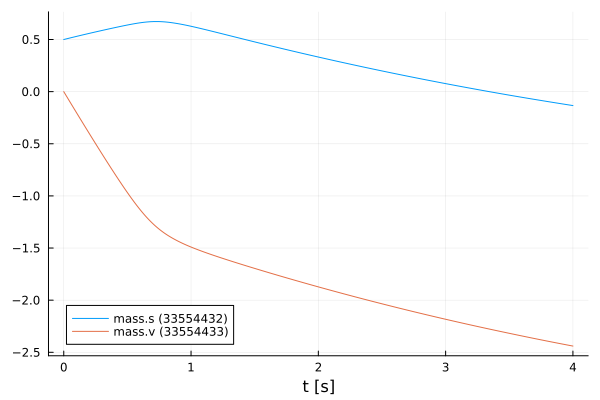

In [20]:
solutionBefore = neuralFMU(x₀)
plot(solutionBefore)

#### Training of the NeuralFMU

For the training of the NeuralFMU the parameters are extracted. All parameters of the first layer are set to the absolute value.

In [21]:
# train
paramsNet = FMIFlux.params(neuralFMU)

for i in 1:length(paramsNet[1])
    if paramsNet[1][i] < 0.0 
        paramsNet[1][i] = -paramsNet[1][i]
    end
end

The well-known Adam optimizer for minimizing the gradient descent is used as further passing parameters. Additionally, the previously defined loss and callback function as well as a one for the number of epochs are passed. Only one epoch is trained so that the NeuralFMU is precompiled.

In [22]:
optim = Adam()
FMIFlux.train!(lossSum, neuralFMU, Iterators.repeated((), 1), optim; cb=()->callb(paramsNet)) 

┌ Info:   Loss [1]: 0.63854
│         Avg displacement in data: 0.79909
└         Weight/Scale: 0.5550727972914904   Bias/Offset: 0.0009999999899930306


Some vectors for collecting data are initialized and the number of runs, epochs and iterations are set.

In [23]:
solutionAfter = []
solutionAfterMod = []
forces = []
displacements = []

numRuns = 2
numEpochs= 5
numIterations = 500;

#### Training loop

The code section shown here represents the training loop. The loop is structured so that it has `numRuns` runs, where each run has `numEpochs` epochs, and the training is performed at each epoch with `numIterations` iterations. In lines 9 and 10, the data for the *neuralFMU* for the default and modified initial states are appended to the corresponding vectors. The plots for the opposition of position and velocity is done in line 13 by calling the function `plot_all_results`. In the following lines the last layers are extracted from the *neuralFMU* and formed into an independent network `netBottom`. The parameters for the `netBottom` network come from the original architecture and are shared. In line 20, the new network is used to represent the friction model in a graph. An analogous construction of the next part of the training loop, where here the first layer is taken from the *neuralFMU* and converted to its own network `netTop`. This network is used to record the displacement model. The different graphs are generated for each run and can thus be compared. 

[ Info: Run: 1/2  Epoch: 1/5


┌ Info:   Loss [51]: 0.45217
│         Avg displacement in data: 0.67244
└         Weight/Scale: 0.6029313724303522   Bias/Offset: 0.04838982765299656


┌ Info:   Loss [101]: 0.38871
│         Avg displacement in data: 0.62346
└         Weight/Scale: 0.6410513949851513   Bias/Offset: 0.08756850831448236


┌ Info:   Loss [151]: 0.35475
│         Avg displacement in data: 0.59561
└         Weight/Scale: 0.6706310149963506   Bias/Offset: 0.11945838429840519


┌ Info:   Loss [201]: 0.3351
│         Avg displacement in data: 0.57887
└         Weight/Scale: 0.6941712990742493   Bias/Offset: 0.14552377553970924


┌ Info:   Loss [251]: 0.323
│         Avg displacement in data: 0.56834
└         Weight/Scale: 0.7130400873342269   Bias/Offset: 0.16663811896379666


┌ Info:   Loss [301]: 0.31495
│         Avg displacement in data: 0.5612
└         Weight/Scale: 0.7281354028361715   Bias/Offset: 0.18339233971686075


┌ Info:   Loss [351]: 0.30855
│         Avg displacement in data: 0.55547
└         Weight/Scale: 0.740084856837268   Bias/Offset: 0.19618836727060648


┌ Info:   Loss [401]: 0.29993
│         Avg displacement in data: 0.54766
└         Weight/Scale: 0.7494160694319267   Bias/Offset: 0.20518935215943215


┌ Info:   Loss [451]: 0.283
│         Avg displacement in data: 0.53198
└         Weight/Scale: 0.7569472367311261   Bias/Offset: 0.21018863983305047


┌ Info:   Loss [501]: 0.2292
│         Avg displacement in data: 0.47875
└         Weight/Scale: 0.7632094527937479   Bias/Offset: 0.20972727943731145
[ Info: Run: 1/2  Epoch: 2/5


┌ Info:   Loss [551]: 0.15297
│         Avg displacement in data: 0.39111
└         Weight/Scale: 0.771629401022109   Bias/Offset: 0.21500804475731453


┌ Info:   Loss [601]: 0.03121
│         Avg displacement in data: 0.17666
└         Weight/Scale: 0.787650243567286   Bias/Offset: 0.23930264096483578


┌ Info:   Loss [651]: 0.02377
│         Avg displacement in data: 0.15419
└         Weight/Scale: 0.7828851006404177   Bias/Offset: 0.23011146473784083


┌ Info:   Loss [701]: 0.02011
│         Avg displacement in data: 0.14183
└         Weight/Scale: 0.7798450526601683   Bias/Offset: 0.22482264872250612


┌ Info:   Loss [751]: 0.01798
│         Avg displacement in data: 0.13409
└         Weight/Scale: 0.7772658711955034   Bias/Offset: 0.22081149169949735


┌ Info:   Loss [801]: 0.01718
│         Avg displacement in data: 0.13105
└         Weight/Scale: 0.7750933426601128   Bias/Offset: 0.21795102714720588


┌ Info:   Loss [851]: 0.01598
│         Avg displacement in data: 0.12642
└         Weight/Scale: 0.7730324919424398   Bias/Offset: 0.21568934323521177


┌ Info:   Loss [901]: 0.01554
│         Avg displacement in data: 0.12465
└         Weight/Scale: 0.7715978561525234   Bias/Offset: 0.21431544165392713


┌ Info:   Loss [951]: 0.01526
│         Avg displacement in data: 0.12355
└         Weight/Scale: 0.7702666418705716   Bias/Offset: 0.2130312385183487


┌ Info:   Loss [1001]: 0.01481
│         Avg displacement in data: 0.12171
└         Weight/Scale: 0.7684254407184646   Bias/Offset: 0.21121329568196207
[ Info: Run: 1/2  Epoch: 3/5


┌ Info:   Loss [1051]: 0.0142
│         Avg displacement in data: 0.11915
└         Weight/Scale: 0.7668959382631991   Bias/Offset: 0.20999993962356156


┌ Info:   Loss [1101]: 0.01399
│         Avg displacement in data: 0.11828
└         Weight/Scale: 0.7653012030773794   Bias/Offset: 0.2089840439563119


┌ Info:   Loss [1151]: 0.01359
│         Avg displacement in data: 0.11658
└         Weight/Scale: 0.7636898030485674   Bias/Offset: 0.2078311399893964


┌ Info:   Loss [1201]: 0.01325
│         Avg displacement in data: 0.11512
└         Weight/Scale: 0.7618859663034143   Bias/Offset: 0.20628265748021046


┌ Info:   Loss [1251]: 0.01306
│         Avg displacement in data: 0.11428
└         Weight/Scale: 0.7600184967859156   Bias/Offset: 0.2045938027787482


┌ Info:   Loss [1301]: 0.01251
│         Avg displacement in data: 0.11185
└         Weight/Scale: 0.7582095071527413   Bias/Offset: 0.202993589760993


┌ Info:   Loss [1351]: 0.0122
│         Avg displacement in data: 0.11044
└         Weight/Scale: 0.756482311833428   Bias/Offset: 0.20155747991998493


┌ Info:   Loss [1401]: 0.01199
│         Avg displacement in data: 0.10952
└         Weight/Scale: 0.7548595245499555   Bias/Offset: 0.20048902075602176


┌ Info:   Loss [1451]: 0.01177
│         Avg displacement in data: 0.10847
└         Weight/Scale: 0.7532735920630736   Bias/Offset: 0.19949097161378487


┌ Info:   Loss [1501]: 0.01152
│         Avg displacement in data: 0.10735
└         Weight/Scale: 0.7516823100367189   Bias/Offset: 0.19827896015678084
[ Info: Run: 1/2  Epoch: 4/5


┌ Info:   Loss [1551]: 0.01124
│         Avg displacement in data: 0.106
└         Weight/Scale: 0.750182571745323   Bias/Offset: 0.19730982006772202


┌ Info:   Loss [1601]: 0.011
│         Avg displacement in data: 0.10489
└         Weight/Scale: 0.7487955151342663   Bias/Offset: 0.19620032287719835


┌ Info:   Loss [1651]: 0.01098
│         Avg displacement in data: 0.1048
└         Weight/Scale: 0.7475788445372039   Bias/Offset: 0.19514121814846536


┌ Info:   Loss [1701]: 0.01063
│         Avg displacement in data: 0.10312
└         Weight/Scale: 0.7462525049433493   Bias/Offset: 0.1939992201601241


┌ Info:   Loss [1751]: 0.01052
│         Avg displacement in data: 0.10256
└         Weight/Scale: 0.7448156095280556   Bias/Offset: 0.1926936152432532


┌ Info:   Loss [1801]: 0.01029
│         Avg displacement in data: 0.10145
└         Weight/Scale: 0.7435895512199522   Bias/Offset: 0.19176767629281724


┌ Info:   Loss [1851]: 0.0102
│         Avg displacement in data: 0.10101
└         Weight/Scale: 0.742109245259767   Bias/Offset: 0.1903780782461428


┌ Info:   Loss [1901]: 0.00983
│         Avg displacement in data: 0.09916
└         Weight/Scale: 0.7408475877921218   Bias/Offset: 0.1893533876659107


┌ Info:   Loss [1951]: 0.00951
│         Avg displacement in data: 0.09751
└         Weight/Scale: 0.7393994495137258   Bias/Offset: 0.187972876578578


┌ Info:   Loss [2001]: 0.00918
│         Avg displacement in data: 0.09579
└         Weight/Scale: 0.7378688998240734   Bias/Offset: 0.18636736684342922
[ Info: Run: 1/2  Epoch: 5/5


┌ Info:   Loss [2051]: 0.00859
│         Avg displacement in data: 0.09269
└         Weight/Scale: 0.7365050851476269   Bias/Offset: 0.18497541583855748


┌ Info:   Loss [2101]: 0.00803
│         Avg displacement in data: 0.0896
└         Weight/Scale: 0.7354684361015168   Bias/Offset: 0.18379229563324992


┌ Info:   Loss [2151]: 0.00708
│         Avg displacement in data: 0.08415
└         Weight/Scale: 0.7348243489079869   Bias/Offset: 0.1827439275131969


┌ Info:   Loss [2201]: 0.00626
│         Avg displacement in data: 0.07914
└         Weight/Scale: 0.7347655539018526   Bias/Offset: 0.18196822305778257


┌ Info:   Loss [2251]: 0.00516
│         Avg displacement in data: 0.07181
└         Weight/Scale: 0.7357443913844411   Bias/Offset: 0.1819644327997506


┌ Info:   Loss [2301]: 0.00428
│         Avg displacement in data: 0.06542
└         Weight/Scale: 0.7377577759431583   Bias/Offset: 0.18313754532892237


┌ Info:   Loss [2351]: 0.00382
│         Avg displacement in data: 0.0618
└         Weight/Scale: 0.739838490634349   Bias/Offset: 0.1848750814058151


┌ Info:   Loss [2401]: 0.00359
│         Avg displacement in data: 0.05995
└         Weight/Scale: 0.7413725876062213   Bias/Offset: 0.18647790525704294


┌ Info:   Loss [2451]: 0.00329
│         Avg displacement in data: 0.0574
└         Weight/Scale: 0.742500623660451   Bias/Offset: 0.18795665864092867


┌ Info:   Loss [2501]: 0.00306
│         Avg displacement in data: 0.05533
└         Weight/Scale: 0.7433218938134586   Bias/Offset: 0.18927364631225366


 95.322249 seconds (1.30 G allocations: 57.671 GiB, 9.14% gc time, 0.08% compilation time)


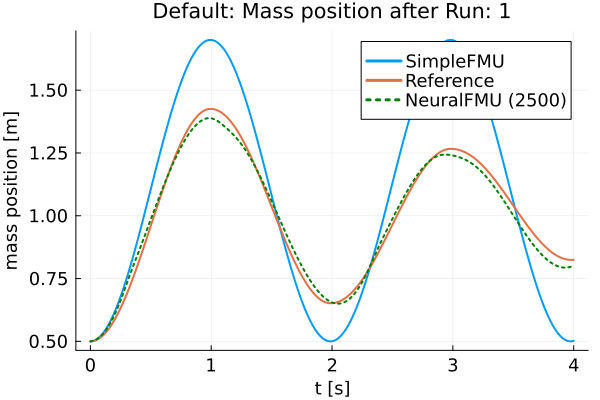

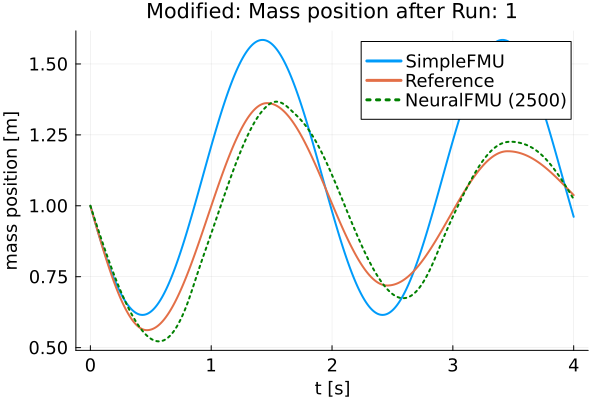

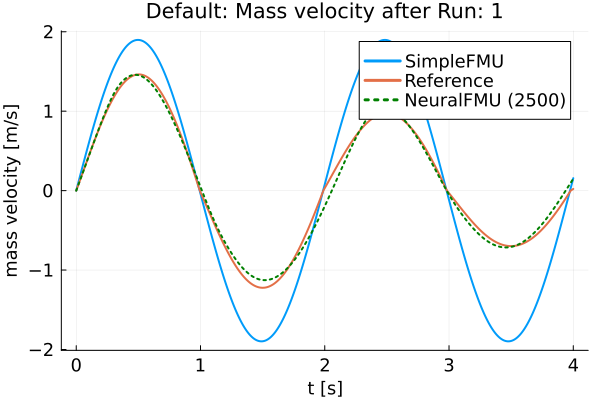

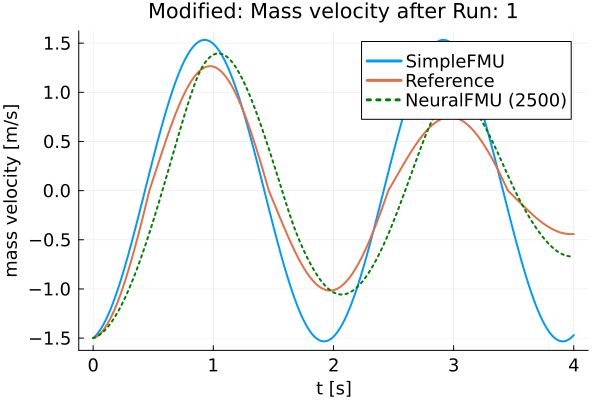

[ Info: Friction model 1 mse: 16.361592438933965


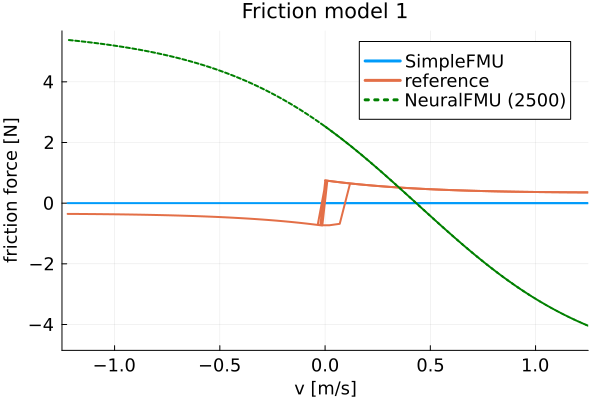

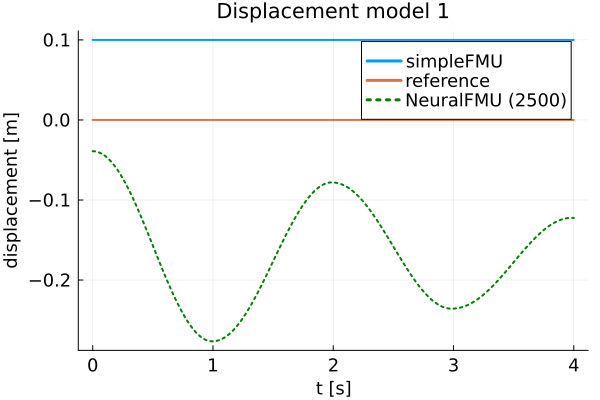

[ Info: Run: 2/2  Epoch: 1/5


┌ Info:   Loss [2551]: 0.00305
│         Avg displacement in data: 0.0552
└         Weight/Scale: 0.7435281093101573   Bias/Offset: 0.18967789433939988


┌ Info:   Loss [2601]: 0.00289
│         Avg displacement in data: 0.05377
└         Weight/Scale: 0.7436609214160486   Bias/Offset: 0.19022706342476403


┌ Info:   Loss [2651]: 0.00277
│         Avg displacement in data: 0.05266
└         Weight/Scale: 0.7437211626609435   Bias/Offset: 0.1908403829493984


┌ Info:   Loss [2701]: 0.0027
│         Avg displacement in data: 0.05193
└         Weight/Scale: 0.7437197106171556   Bias/Offset: 0.19150495601581075


┌ Info:   Loss [2751]: 0.00268
│         Avg displacement in data: 0.0518
└         Weight/Scale: 0.743679943951006   Bias/Offset: 0.19221839889176712


┌ Info:   Loss [2801]: 0.00253
│         Avg displacement in data: 0.05034
└         Weight/Scale: 0.7436324909825957   Bias/Offset: 0.19299024642519264


┌ Info:   Loss [2851]: 0.00241
│         Avg displacement in data: 0.04906
└         Weight/Scale: 0.7435976943907705   Bias/Offset: 0.19382645278154695


┌ Info:   Loss [2901]: 0.00233
│         Avg displacement in data: 0.04824
└         Weight/Scale: 0.7435932413987915   Bias/Offset: 0.1947371654205788


┌ Info:   Loss [2951]: 0.00226
│         Avg displacement in data: 0.04754
└         Weight/Scale: 0.7436079500477933   Bias/Offset: 0.19570768421059798


┌ Info:   Loss [3001]: 0.00218
│         Avg displacement in data: 0.04671
└         Weight/Scale: 0.7436205870313314   Bias/Offset: 0.19670094106644978


[ Info: Run: 2/2  Epoch: 2/5
┌ Info:   Loss [3051]: 0.0021
│         Avg displacement in data: 0.04581
└         Weight/Scale: 0.7436300038238293   Bias/Offset: 0.19769511634000003


┌ Info:   Loss [3101]: 0.00202
│         Avg displacement in data: 0.04499
└         Weight/Scale: 0.7436462016384935   Bias/Offset: 0.1986844241437043


┌ Info:   Loss [3151]: 0.00195
│         Avg displacement in data: 0.04412
└         Weight/Scale: 0.7436766954828821   Bias/Offset: 0.19966702455068028


┌ Info:   Loss [3201]: 0.00185
│         Avg displacement in data: 0.04299
└         Weight/Scale: 0.74372332233067   Bias/Offset: 0.20064507766983528


┌ Info:   Loss [3251]: 0.00173
│         Avg displacement in data: 0.04164
└         Weight/Scale: 0.7437868048614678   Bias/Offset: 0.20162342256028545


┌ Info:   Loss [3301]: 0.00174
│         Avg displacement in data: 0.04172
└         Weight/Scale: 0.7438662090904797   Bias/Offset: 0.202604162588


┌ Info:   Loss [3351]: 0.00159
│         Avg displacement in data: 0.03987
└         Weight/Scale: 0.7439566212258771   Bias/Offset: 0.2035846174349373


┌ Info:   Loss [3401]: 0.00147
│         Avg displacement in data: 0.0383
└         Weight/Scale: 0.7440509951068351   Bias/Offset: 0.2045588571809616


┌ Info:   Loss [3451]: 0.00164
│         Avg displacement in data: 0.04047
└         Weight/Scale: 0.744141760736745   Bias/Offset: 0.20551928474303902


┌ Info:   Loss [3501]: 0.00137
│         Avg displacement in data: 0.03697
└         Weight/Scale: 0.7442260219496951   Bias/Offset: 0.20646418035259262


[ Info: Run: 2/2  Epoch: 3/5
┌ Info:   Loss [3551]: 0.00134
│         Avg displacement in data: 0.03659
└         Weight/Scale: 0.7442956503678974   Bias/Offset: 0.2073903050852546


┌ Info:   Loss [3601]: 0.00123
│         Avg displacement in data: 0.03503
└         Weight/Scale: 0.7443401234511142   Bias/Offset: 0.20828742524715227


┌ Info:   Loss [3651]: 0.00124
│         Avg displacement in data: 0.03523
└         Weight/Scale: 0.7443840759460465   Bias/Offset: 0.2091944987585432


┌ Info:   Loss [3701]: 0.00111
│         Avg displacement in data: 0.03334
└         Weight/Scale: 0.7444329645945319   Bias/Offset: 0.21013790350655728


┌ Info:   Loss [3751]: 0.00103
│         Avg displacement in data: 0.03216
└         Weight/Scale: 0.7444858097149997   Bias/Offset: 0.21113689394030072


┌ Info:   Loss [3801]: 0.001
│         Avg displacement in data: 0.03158
└         Weight/Scale: 0.7444976416499824   Bias/Offset: 0.21215414983115582


┌ Info:   Loss [3851]: 0.00095
│         Avg displacement in data: 0.03083
└         Weight/Scale: 0.7445344199024972   Bias/Offset: 0.21323981408731982


┌ Info:   Loss [3901]: 0.0009
│         Avg displacement in data: 0.03007
└         Weight/Scale: 0.7443240839031844   Bias/Offset: 0.2141146141331864


┌ Info:   Loss [3951]: 0.00087
│         Avg displacement in data: 0.02956
└         Weight/Scale: 0.7440345750292984   Bias/Offset: 0.21478353745868745


┌ Info:   Loss [4001]: 0.00083
│         Avg displacement in data: 0.02882
└         Weight/Scale: 0.7437660597078951   Bias/Offset: 0.21531225073492988
[ Info: Run: 2/2  Epoch: 4/5


┌ Info:   Loss [4051]: 0.00084
│         Avg displacement in data: 0.02905
└         Weight/Scale: 0.7434687194960459   Bias/Offset: 0.21576960054447258


┌ Info:   Loss [4101]: 0.00079
│         Avg displacement in data: 0.02819
└         Weight/Scale: 0.7431664266415255   Bias/Offset: 0.21619348596050633


┌ Info:   Loss [4151]: 0.00075
│         Avg displacement in data: 0.02746
└         Weight/Scale: 0.7428581722240827   Bias/Offset: 0.21658709201456758


┌ Info:   Loss [4201]: 0.00073
│         Avg displacement in data: 0.02707
└         Weight/Scale: 0.7425549955003684   Bias/Offset: 0.2169666384812941


┌ Info:   Loss [4251]: 0.00071
│         Avg displacement in data: 0.02665
└         Weight/Scale: 0.7422465397481612   Bias/Offset: 0.21728340094696036


┌ Info:   Loss [4301]: 0.00069
│         Avg displacement in data: 0.0262
└         Weight/Scale: 0.741930247318658   Bias/Offset: 0.21760596396288553


┌ Info:   Loss [4351]: 0.00066
│         Avg displacement in data: 0.02575
└         Weight/Scale: 0.7416057911362831   Bias/Offset: 0.21793214046407522


┌ Info:   Loss [4401]: 0.00064
│         Avg displacement in data: 0.02532
└         Weight/Scale: 0.7412743341120902   Bias/Offset: 0.21825771626452709


┌ Info:   Loss [4451]: 0.00062
│         Avg displacement in data: 0.02488
└         Weight/Scale: 0.7409499671937096   Bias/Offset: 0.2185953589900754


┌ Info:   Loss [4501]: 0.0006
│         Avg displacement in data: 0.0245
└         Weight/Scale: 0.7406330811683198   Bias/Offset: 0.21891731339468345
[ Info: Run: 2/2  Epoch: 5/5


┌ Info:   Loss [4551]: 0.00058
│         Avg displacement in data: 0.02413
└         Weight/Scale: 0.7403133869864003   Bias/Offset: 0.21926062073820357


┌ Info:   Loss [4601]: 0.00057
│         Avg displacement in data: 0.02378
└         Weight/Scale: 0.7399938858804632   Bias/Offset: 0.21963071021599087


┌ Info:   Loss [4651]: 0.00055
│         Avg displacement in data: 0.02347
└         Weight/Scale: 0.7396708373093254   Bias/Offset: 0.2200210435015318


┌ Info:   Loss [4701]: 0.00054
│         Avg displacement in data: 0.02325
└         Weight/Scale: 0.7393384559399098   Bias/Offset: 0.22042175803561356


┌ Info:   Loss [4751]: 0.00053
│         Avg displacement in data: 0.02307
└         Weight/Scale: 0.7390309370031888   Bias/Offset: 0.220809013950127


┌ Info:   Loss [4801]: 0.00052
│         Avg displacement in data: 0.02286
└         Weight/Scale: 0.7387158108643203   Bias/Offset: 0.22121887231322257


┌ Info:   Loss [4851]: 0.00052
│         Avg displacement in data: 0.02274
└         Weight/Scale: 0.7383929430793872   Bias/Offset: 0.2216556536040632


┌ Info:   Loss [4901]: 0.00051
│         Avg displacement in data: 0.02268
└         Weight/Scale: 0.7380559306346696   Bias/Offset: 0.22210146458687813


┌ Info:   Loss [4951]: 0.00051
│         Avg displacement in data: 0.02253
└         Weight/Scale: 0.7377009211825626   Bias/Offset: 0.22254356655440413


┌ Info:   Loss [5001]: 0.0005
│         Avg displacement in data: 0.02229
└         Weight/Scale: 0.7373263426162331   Bias/Offset: 0.22297302816772924


 84.325945 seconds (1.17 G allocations: 52.146 GiB, 8.25% gc time)


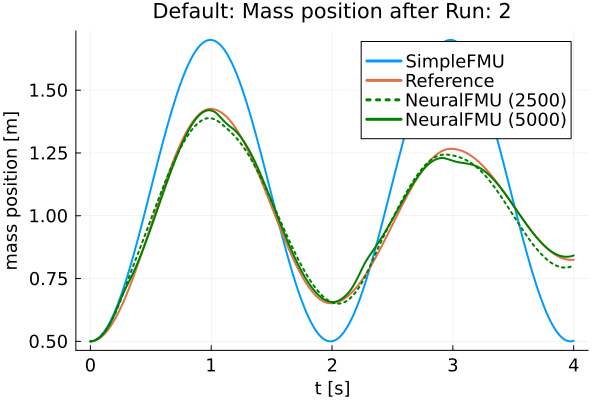

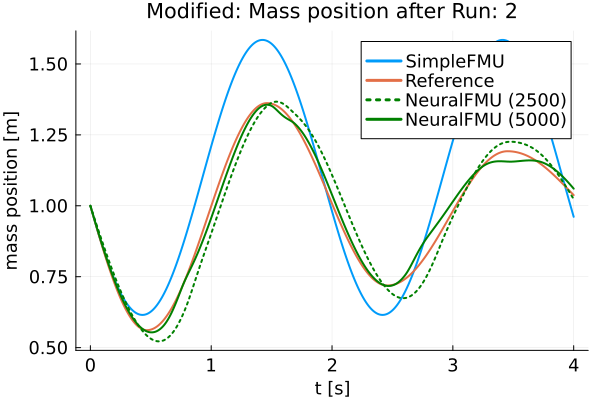

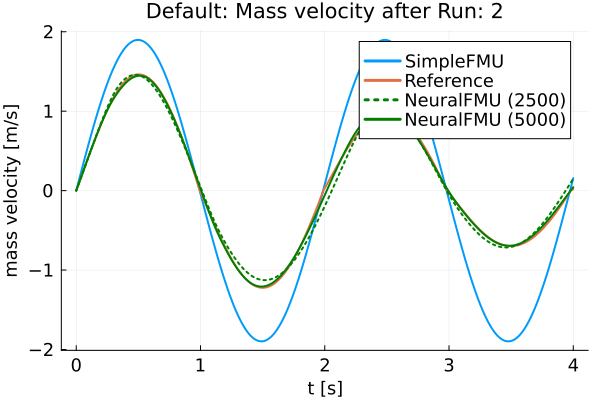

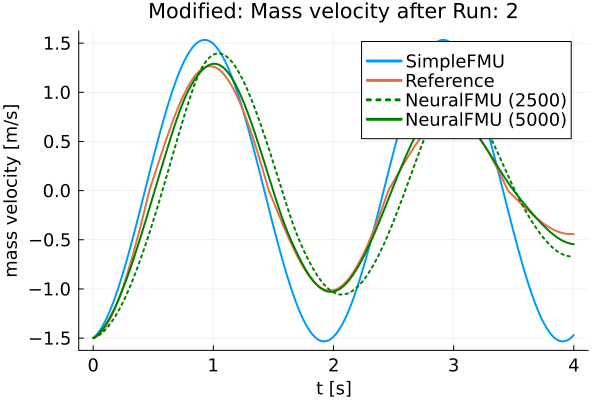

[ Info: Friction model 1 mse: 16.361592438933965
[ Info: Friction model 2 mse: 18.48808057879939


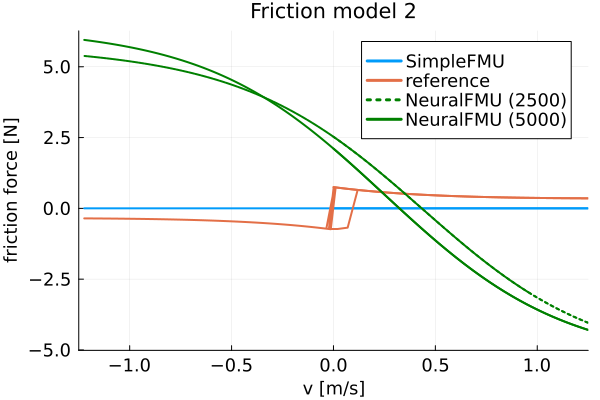

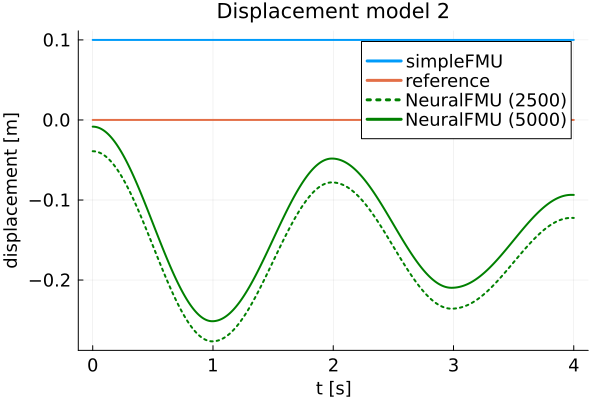

In [24]:
for run in 1:numRuns

    global forces, displacements
    
    optim = Adam(10.0^(-3+1-run)) # going from 1e-3 to 1e-4

    @time for epoch in 1:numEpochs
        @info "Run: $(run)/$(numRuns)  Epoch: $(epoch)/$(numEpochs)"
        FMIFlux.train!(lossSum, neuralFMU, Iterators.repeated((), numIterations), optim; cb=()->callb(paramsNet))
    end
    flush(stderr)
    flush(stdout)
    
    push!(solutionAfter, neuralFMU(x₀))
    push!(solutionAfterMod, neuralFMU(xMod₀))

    # generate all plots for the position and velocity
    plot_all_results(realSimData, realSimDataMod, simpleSimData, simpleSimDataMod, solutionAfter, solutionAfterMod)
    
    # friction model extraction
    layersBottom = neuralFMU.model.layers[3:5]
    netBottom = Chain(layersBottom...)
    transferFlatParams!(netBottom, paramsNet, 7)
    
    plot_friction_model!(realSimData, netBottom, forces) 
    
    # displacement model extraction
    layersTop = neuralFMU.model.layers[1:1]
    netTop = Chain(layersTop...)
    transferFlatParams!(netTop, paramsNet, 1)

    plot_displacement_model!(realSimData, netTop, displacements, tSave, displacement)
end

Finally, the FMUs are cleaned-up.

In [25]:
unloadFMU(simpleFMU)
unloadFMU(realFMU)

### Summary

Based on the plots, it can be seen that the curves of the *realFMU* and the *neuralFMU* are very close. The *neuralFMU* is able to learn the friction and displacement model.

### Source

[1] Tobias Thummerer, Lars Mikelsons and Josef Kircher. 2021. **NeuralFMU: towards structural integration of FMUs into neural networks.** Martin Sjölund, Lena Buffoni, Adrian Pop and Lennart Ochel (Ed.). Proceedings of 14th Modelica Conference 2021, Linköping, Sweden, September 20-24, 2021. Linköping University Electronic Press, Linköping (Linköping Electronic Conference Proceedings ; 181), 297-306. [DOI: 10.3384/ecp21181297](https://doi.org/10.3384/ecp21181297)
